# Custom Transformer

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [2]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

<AxesSubplot:xlabel='days_until_delivery', ylabel='Count'>

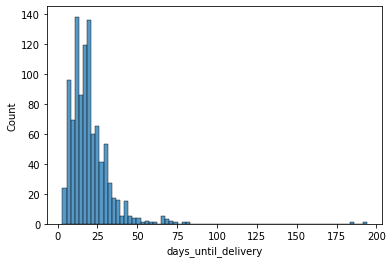

In [3]:
# Check target
sns.histplot(data.days_until_delivery)

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look wierd, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [36]:
data["customer_state"].unique()

array(['RJ', 'SP', 'MG', 'RS', 'BA', 'PR', 'RN', 'CE', 'MS', 'SE', 'AL',
       'SC', 'MA', 'PA', 'ES', 'PB', 'AM', 'GO', 'PE', 'DF', 'PI', 'MT',
       'TO', 'RO', 'AP'], dtype=object)

In [27]:
data["volume"] = data["product_length_cm"]*data["product_height_cm"]*data["product_width_cm"]
X=data.drop(columns = "days_until_delivery")
y=data["days_until_delivery"]

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer

# Preprocessor
num_transformer = make_pipeline(SimpleImputer(), MinMaxScaler())
cat_transformer = OneHotEncoder(drop = "if_binary")

preproc = make_column_transformer(
    (num_transformer, make_column_selector(dtype_include=['float64'])),
    (cat_transformer, make_column_selector(dtype_include=['object','bool']))
)

# Add Estimator
pipe = make_pipeline(preproc, Ridge())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff530ae8700>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff530ae8310>)])),
                ('ridge', Ridge())])

#### 🧪 Test your pipe

In [11]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X,y)

result = ChallengeResult('pipe', 
                         shape = pipe_test[:-1].fit_transform(X).shape
)
result.write()
print(result.check())

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/cherif/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/cherif/code/cherifbenham/data-challenges/05-ML/08-Workflow/02-Custom-Transformer
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_pipe.py::TestPipe::test_pipe_not_crashing PASSED              [100%]

============================== 1 passed in 0.44s ===============================


💯 You can commit your code:

git add tests/pipe.pickle

git commit -m 'Completed pipe step'

git push origin master


## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [25]:
new_data = pd.read_csv("data_new.csv")

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,volume
0,RJ,SP,1825,53,10,40,21200
1,RJ,SP,700,65,18,28,32760
2,RJ,SP,1825,53,10,40,21200
3,RJ,SP,1825,53,10,40,21200
4,RJ,SP,1825,53,10,40,21200
...,...,...,...,...,...,...,...
995,RJ,SP,16800,63,58,24,87696
996,RS,SP,675,40,18,35,25200
997,RJ,SP,2050,45,15,35,23625
998,BA,SP,8750,52,51,17,45084


In [28]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(pipe,X,y,cv=5)
cv_score

/home/cherif/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/cherif/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/cherif/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 105, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/home/cherif/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/cherif/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 113, in <lambda>
    out = lambda 

array([0.0071741 ,        nan, 0.06779167,        nan,        nan])

In [33]:
pipe.fit(X,y)
prediction = pipe.predict(new_data)
prediction

array([23.88611958])

In [34]:
from nbresult import ChallengeResult

result = ChallengeResult('prediction',
    prediction = prediction
)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-6.2.5, py-1.11.0, pluggy-1.0.0 -- /home/cherif/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/cherif/code/cherifbenham/data-challenges/05-ML/08-Workflow/02-Custom-Transformer
plugins: anyio-3.4.0
collecting ... collected 1 item

tests/test_prediction.py::TestPrediction::test_prediction PASSED         [100%]

============================== 1 passed in 0.38s ===============================


💯 You can commit your code:

git add tests/prediction.pickle

git commit -m 'Completed prediction step'

git push origin master


🏁 Congratulation. Don't forget to add, commit and push your notebook.